In [2]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

import matplotlib.pyplot as plt

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0, "../../pompjax/pompjax/")
sys.path.insert(0, "../..")
sys.path.insert(0, "../")

from global_config import config

results_dir          = config.get_property('results_dir')
results2_dir         = config.get_property('results2_dir')
data_dir             = config.get_property('data_dir')
paper_dir            = config.get_property('paper_dir')
data_db_dir          = config.get_property('data_db_dir')

data_cluster_dir     = config.get_property('data_cluster_dir')
results_cluster_dir  = config.get_property('results_cluster_dir')

feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")


In [3]:
gammas_search = [5/100, 10/100, 15/100]
betas_search  = [0.01, 0.05, 0.1]
rho_search    = [1/100, 5/100, 10/100, 15/100]

idx_sce = 0
scenarios_large_df = pd.DataFrame(columns=["scenario", "gamma", "beta", "rho"])

for g in gammas_search:
    for b in betas_search:
        for r in rho_search:
            df = pd.DataFrame({"scenario": f"scenario{int(idx_sce+1)}",
                                                            "gamma": g,
                                                            "beta": b,
                                                            "rho": r}, index=[0])
            scenarios_large_df = pd.concat([scenarios_large_df, df], axis=0).reset_index(drop=True)
            idx_sce += 1

/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_80468/2068480524.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scenarios_large_df = pd.concat([scenarios_large_df, df], axis=0).reset_index(drop=True)


In [4]:
from utils_local import plot_utils
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
import seaborn as sns

path_to_results = "/Users/chaosdonkey06/Dropbox/shaman-lab/amr-hospitals2/results"
path_to_samples = os.path.join(path_to_results, "synthetic_inferences")

infer_id = str(1).zfill(3)

In [5]:
scenarios_large_df[scenarios_large_df.gamma==0.10]

,scenario,gamma,beta,rho
12,scenario13,0.1,0.01,0.01
13,scenario14,0.1,0.01,0.05
14,scenario15,0.1,0.01,0.10
15,scenario16,0.1,0.01,0.15
16,scenario17,0.1,0.05,0.01
17,scenario18,0.1,0.05,0.05
18,scenario19,0.1,0.05,0.10
19,scenario20,0.1,0.05,0.15
20,scenario21,0.1,0.10,0.01
21,scenario22,0.1,0.10,0.05


/Users/chaosdonkey06/Dropbox/My Mac (Jaimes-MacBook-Pro.local)/Desktop/Shaman-lab/AMR_ABM2/abm/reviews_epidemics/../../pompjax/pompjax/diagnostic_plots/diagnostic_plot.py:32: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()
/Users/chaosdonkey06/Dropbox/My Mac (Jaimes-MacBook-Pro.local)/Desktop/Shaman-lab/AMR_ABM2/abm/reviews_epidemics/../../pompjax/pompjax/diagnostic_plots/diagnostic_plot.py:32: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()
/Users/chaosdonkey06/Dropbox/My Mac (Jaimes-MacBook-Pro.local)/Desktop/Shaman-lab/AMR_ABM2/abm/reviews_epidemics/../../pompjax/pompjax/diagnostic_plots/diagnostic_plot.py:32: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()
/Users/chaosdonkey06/Dropbox/My Ma

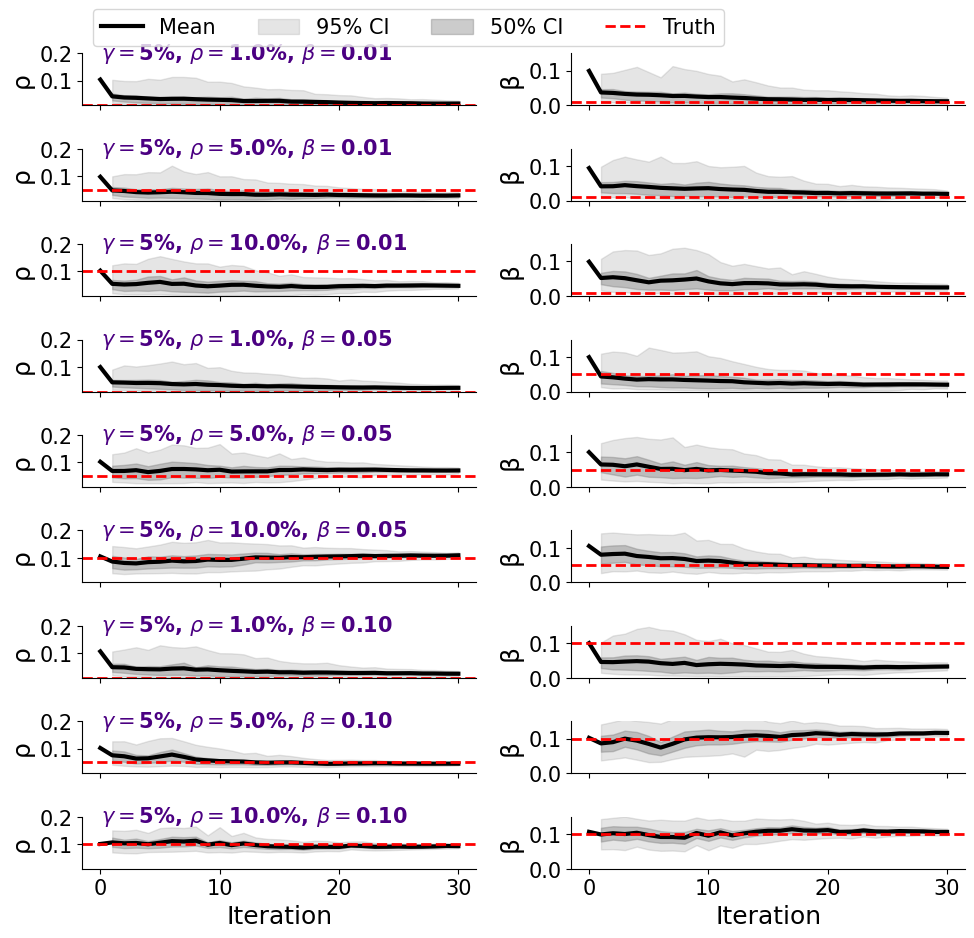

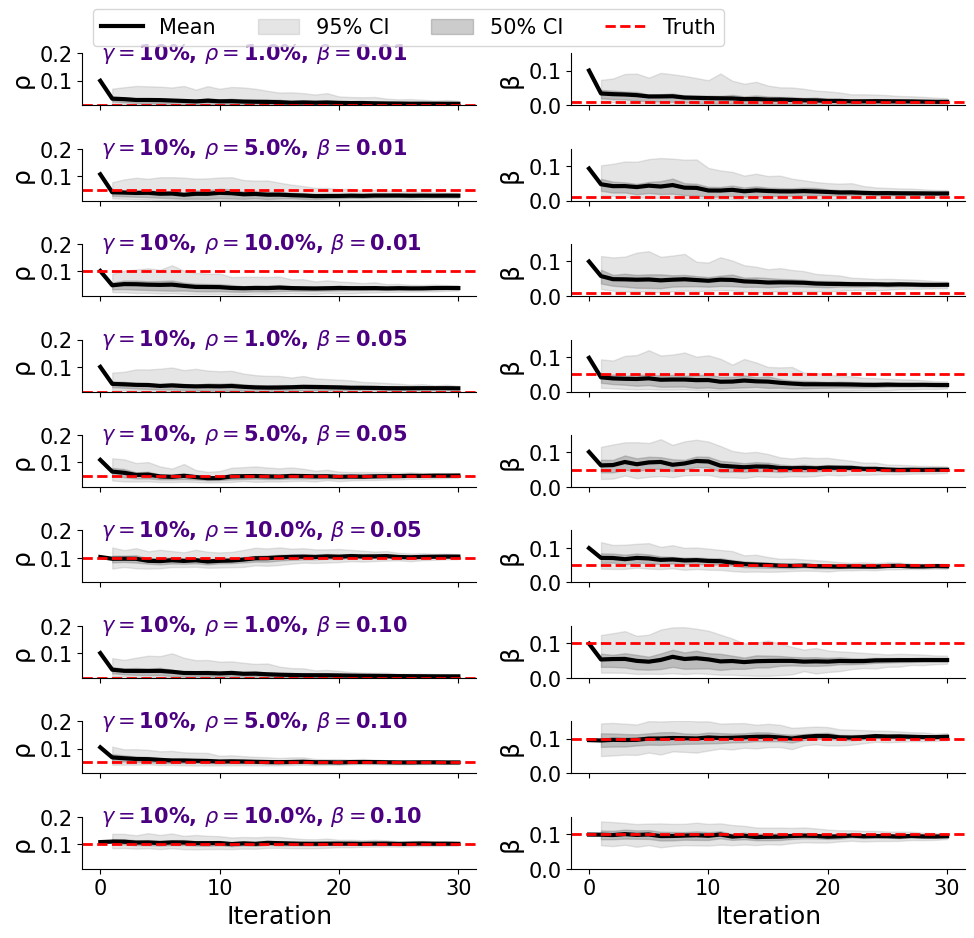

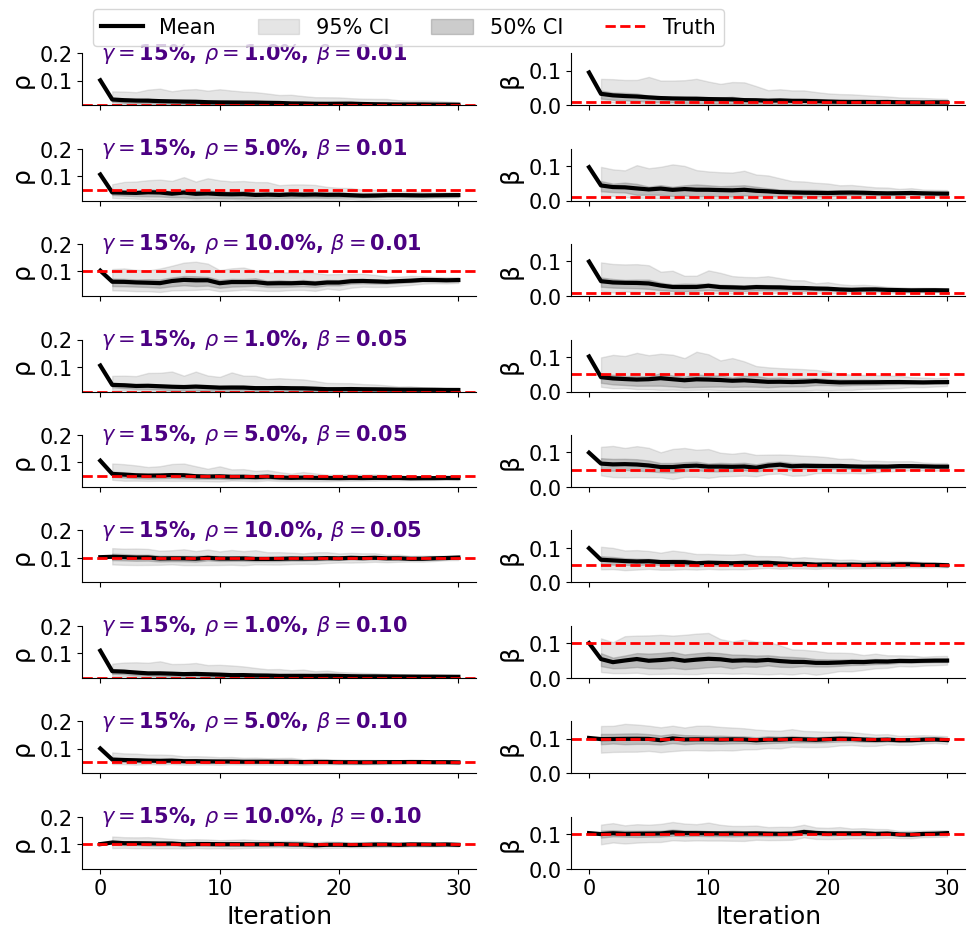

In [6]:
from diagnostic_plots import convergence_plot
from utils import create_df_response

for γ in [0.05, 0.10, 0.15]:

    sce_df = scenarios_large_df[scenarios_large_df.gamma==γ].reset_index(drop=True)
    sce_df = sce_df[sce_df.rho!=0.15].reset_index(drop=True)
    i_ax   = 0

    fig, axes = plt.subplots(len(sce_df), 2, figsize=(10, 10.2), sharex=True, sharey="col")

    for idx_row, row in sce_df.iterrows():

        row          = sce_df.iloc[idx_row]
        samples_path = os.path.join(path_to_samples, row["scenario"], f"{infer_id}posterior.npz")

        samples_inference = np.load(samples_path)

        θpost = samples_inference["posterior"]
        θmle  = samples_inference["mle"]
        Nif   = θpost.shape[-1]
        θpost = θpost[:, :, :, :].mean(-2)

        ρ_df = create_df_response(θpost[0, :, :].T, time=Nif)
        β_df = create_df_response(θpost[1, :, :].T, time=Nif)

        p_dfs       = [ρ_df, β_df]
        param_label = ["ρ", "β"]
        p_truth     = [row.rho, row.beta]

        parameters_range  = np.array([[0.01, 20/100], [0, 0.15]])
        convergence_plot(θmle, p_dfs, parameters_range, param_label, ax=axes[i_ax, :], fig=fig, param_truth=p_truth)
        axes[i_ax, 0].legend().remove(); axes[i_ax, 1].legend().remove()

        axes[i_ax, 0].text(x=0.1, y=0.18,
                        s=r"$\gamma=${:0.0f}%, $\rho=${:0.1f}%, $\beta=${:0.2f}".format(row.gamma*100, row.rho*100, row.beta),
                            weight='bold',
                            color="indigo")

        axes[i_ax, 1].set_xlabel(None)
        i_ax += 1

    axes[0, 0].legend(loc="upper left", bbox_to_anchor=(0.0, 2.05), ncol=4)

    axes[-1, 0].set_xlabel("Iteration")
    axes[-1, 1].set_xlabel("Iteration")

    for axi in axes.flatten():
        axi.spines['right'].set_visible(False)
        axi.spines['top'].set_visible(False)

    fig.savefig(os.path.join("figures", "convergence_plots_gamma{}.png".format(γ)),
                                        dpi=300, bbox_inches='tight', transparent=True)


In [7]:
posterior_df = pd.DataFrame()

for idx_row, row in scenarios_large_df.iterrows():
    if row.rho==0.15:
        continue

    samples_path = os.path.join(path_to_samples, row["scenario"], f"{infer_id}posterior.npz")
    inference    = np.load(samples_path)

    θmle      = inference["mle"]
    θpost     = inference["posterior"]
    y_sim     = inference["observations"]
    θtruth    = inference["teta_truth"]
    idx_infer = inference["idx_infer"]
    Nif       = θpost.shape[-1]

    ρ_post = θpost[0, :, :, :].mean(-2).flatten()
    β_post = θpost[1, :, :, :].mean(-2).flatten()

    post_df                = pd.DataFrame(columns=["value", "param", "ens_id", "if_iter"])
    post_df["value"]       = np.concatenate([ρ_post, β_post])
    post_df["value_truth"] = np.concatenate([θtruth[0, 0]*np.ones_like(ρ_post), θtruth[1, 0]*np.ones_like(β_post)])

    post_df["param"]    = ["ρ"] * len(ρ_post) + ["β"] * len(β_post)
    post_df["if_iter"]  = flatten_list([list(range(Nif)) * 300  ] * 2 )
    post_df["ens_id"]   = flatten_list([[i] * Nif for i in range( 300 )] * 2)
    post_df["gamma"]    = row.gamma
    post_df["scenario"] = idx_row

    posterior_df        = pd.concat([posterior_df, post_df])

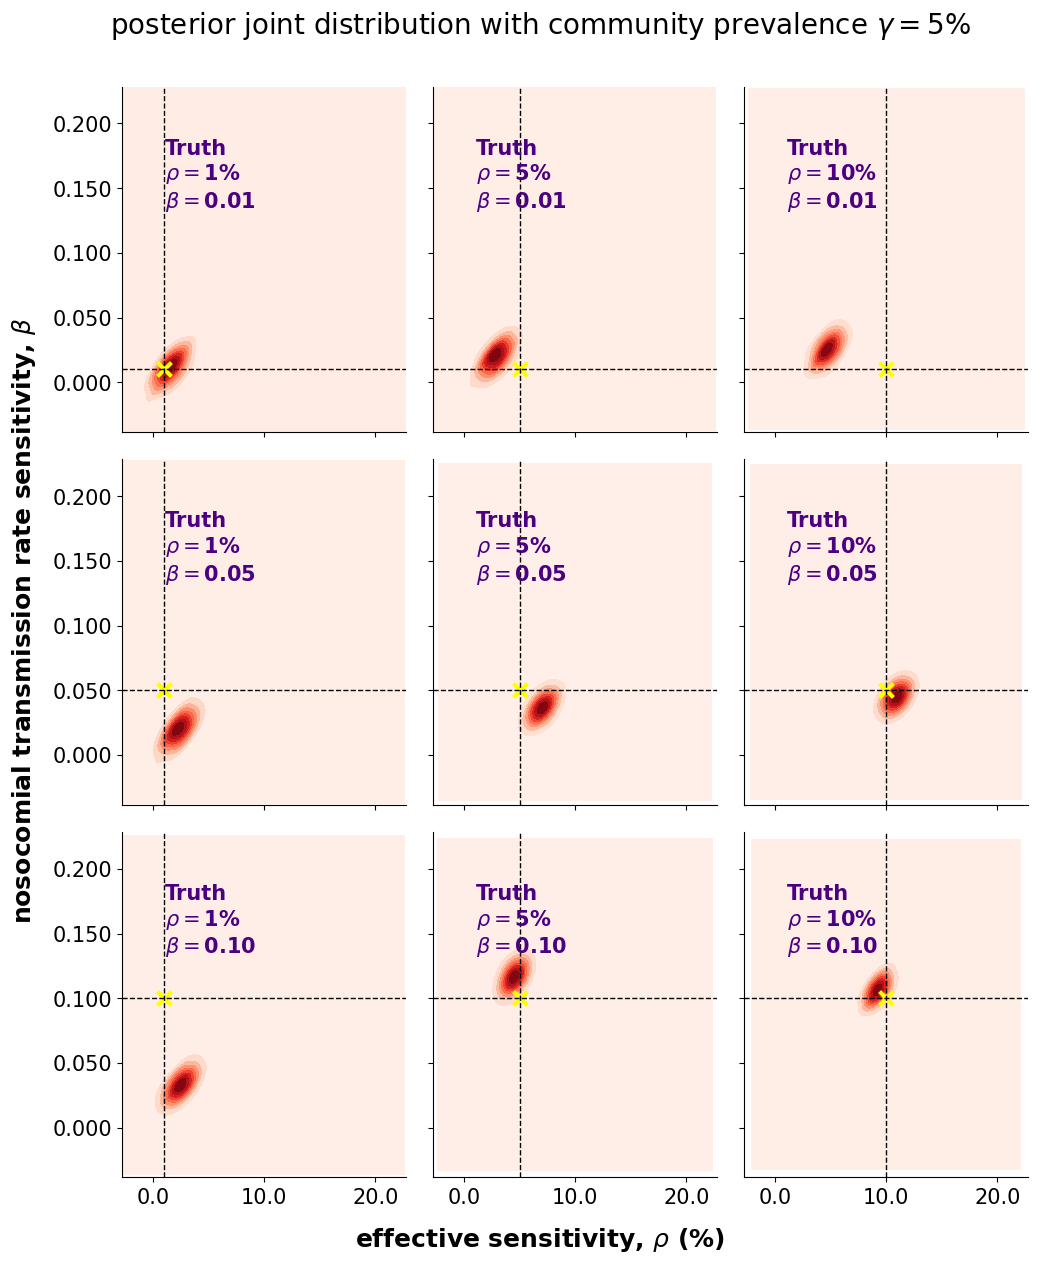

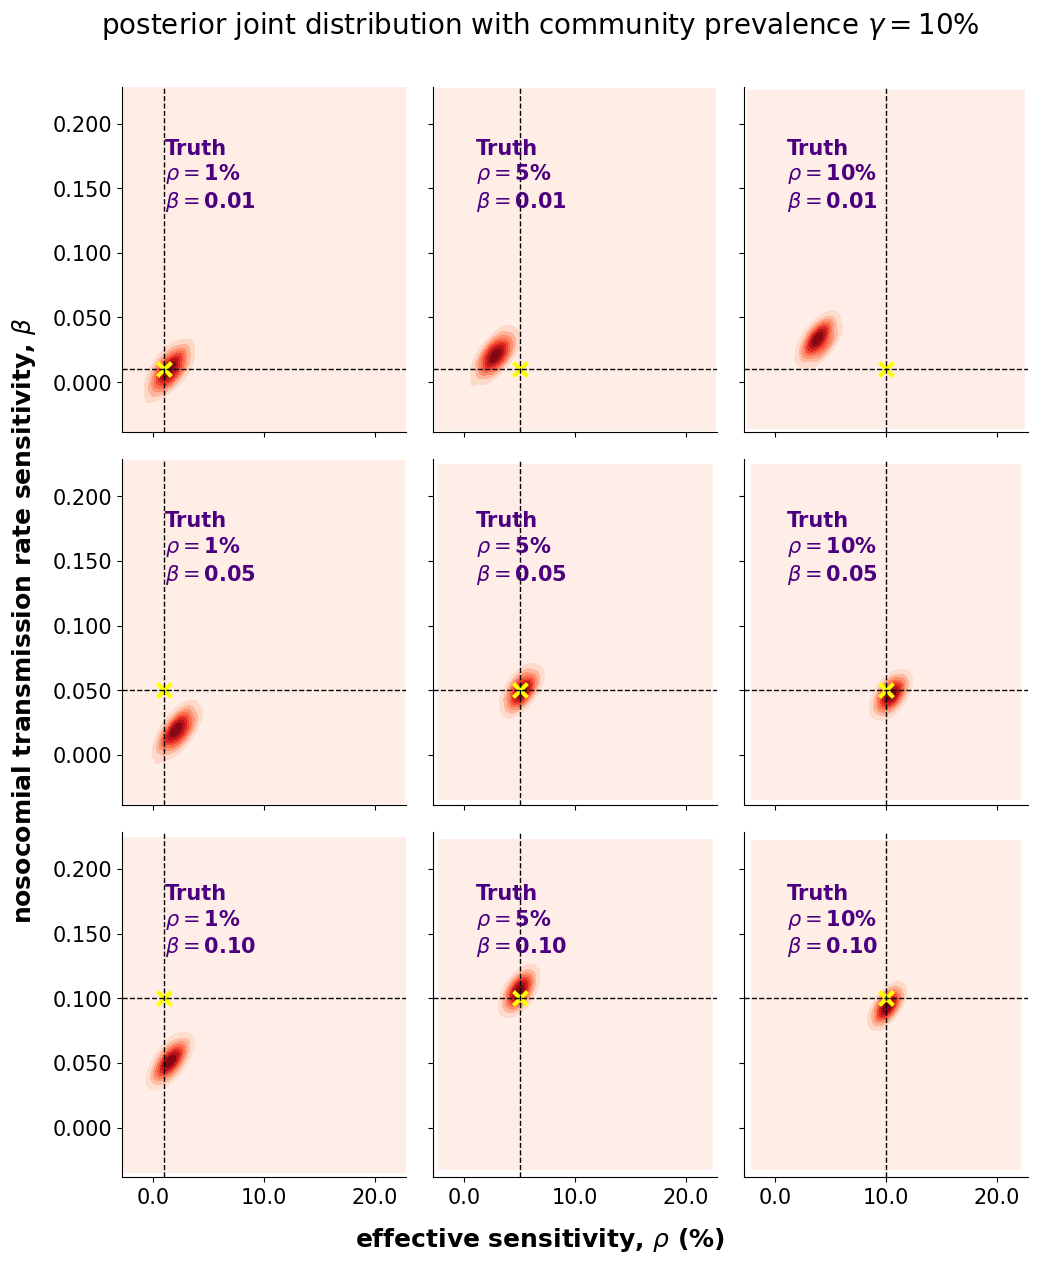

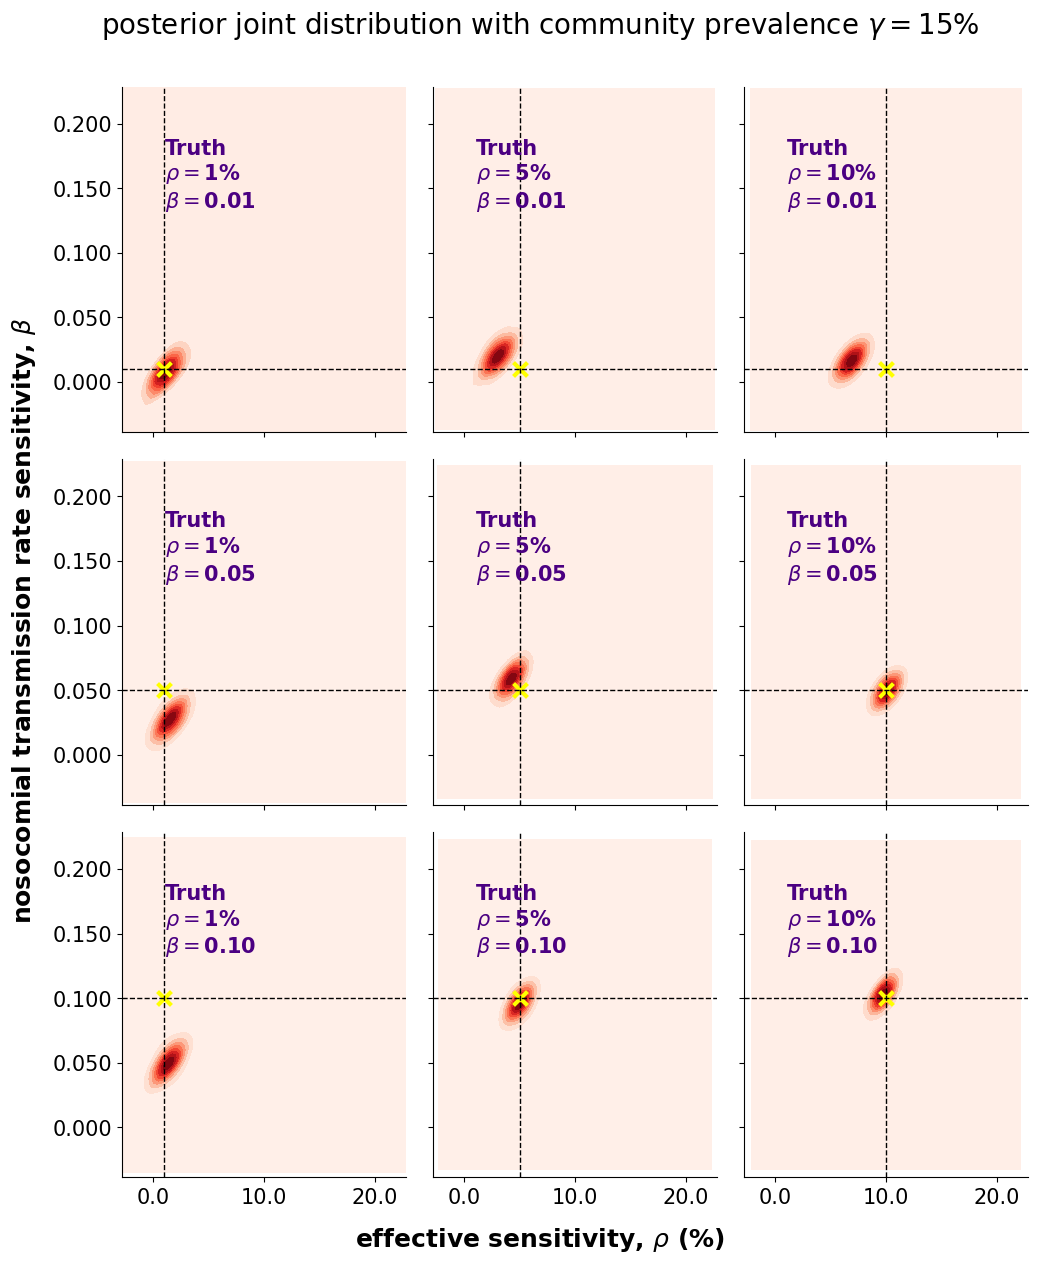

In [8]:
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
import seaborn as sns

v_df = posterior_df[posterior_df["if_iter"] == Nif-1]

for idx_gamma, gamma in enumerate([0.05, 0.1, 0.15]):
    fig, axes = plt.subplots(3, 3, figsize=(10.2, 12.2), sharey=True, sharex=True)

    for idx_scenario, ax in enumerate(axes.flatten()):

        p_df             = v_df[v_df.gamma==gamma]
        p_df             = p_df[p_df["scenario"] == p_df["scenario"].unique()[idx_scenario]]

        rho_df           = p_df[p_df["param"] == "ρ"].reset_index(drop=True)
        beta_df          = p_df[p_df["param"] == "β"].reset_index(drop=True)
        rho_df["value"]  = rho_df["value"] * 100

        sns.kdeplot(ax    = ax,
                    x     = list(rho_df["value"].values) + [0, 20]*5,
                    y     = list(beta_df["value"])       + [-0.01, 0.2]*5,
                    cmap  = "Reds",
                    fill  = True,  thresh=0)

        ax.axhline(y=beta_df["value_truth"].drop_duplicates().values[0], color="k", lw=1, ls="--")
        ax.axvline(x=rho_df["value_truth"].drop_duplicates().values[0] * 100, color="k", lw=1, ls="--")

        ax.scatter(x          = rho_df["value_truth"].drop_duplicates()*100,
                    y         = beta_df["value_truth"].drop_duplicates(),
                    marker    = "x",
                    facecolor = "yellow",
                    lw        = 3,
                    s         = 100)

        ax.text(x = 0.15,
                y = 0.65,
                s = "Truth\n"+r"$\rho=${:0.0f}%".format(rho_df["value_truth"].drop_duplicates().values[0]*100,) +"\n"+
                        r"$\beta=${:0.2f}".format(beta_df["value_truth"].drop_duplicates().values[0]),
                weight='bold', color="indigo", transform=ax.transAxes)
        ax.set_xlabel(None)
        ax.set_ylabel(None)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

    fig.suptitle("posterior joint distribution with community prevalence $\gamma=${:0.0f}%".format(gamma*100), x=0.5, y=1.)

    for axi in axes.flatten():
        axi.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))
        axi.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
    plt.tight_layout()

    fig.supylabel(r"nosocomial transmission rate sensitivity, $\beta$", x=-0.02, y=0.5, weight='bold')
    fig.supxlabel(r"effective sensitivity, $\rho$ (%)", x=0.5, y=-0.02, weight='bold')

    fig.savefig(os.path.join("figures", "joint_distribution_gamma{}.png".format(gamma)),
                                        dpi=300, bbox_inches='tight', transparent=True)


In [61]:
fig     = plt.figure(constrained_layout=True, figsize=(14.5, 15.2))
subfigs = fig.subfigures(2, 2, hspace=0.1, wspace=0.05, height_ratios=[0.5, 0.5], width_ratios=[0.5, 0.5])


v_df = posterior_df[posterior_df["if_iter"] == Nif-1]

for idx_gamma, gamma in enumerate([0.05, 0.1, 0.15]):

    axes = subfigs.flatten()[idx_gamma].subplots(3, 3, sharex=True, sharey=True)

    for idx_scenario, ax in enumerate(axes.flatten()):

        p_df             = v_df[v_df.gamma==gamma]
        p_df             = p_df[p_df["scenario"] == p_df["scenario"].unique()[idx_scenario]]

        rho_df           = p_df[p_df["param"] == "ρ"].reset_index(drop=True)
        beta_df          = p_df[p_df["param"] == "β"].reset_index(drop=True)
        rho_df["value"]  = rho_df["value"] * 100

        sns.kdeplot(ax    = ax,
                    x     = list(rho_df["value"].values) + [0, 20]*5,
                    y     = list(beta_df["value"])       + [-0.01, 0.2]*5,
                    cmap  = "Reds",
                    fill  = True,  thresh=0)

        ax.axhline(y=beta_df["value_truth"].drop_duplicates().values[0], color="k", lw=1, ls="--")
        ax.axvline(x=rho_df["value_truth"].drop_duplicates().values[0] * 100, color="k", lw=1, ls="--")

        ax.scatter(x          = rho_df["value_truth"].drop_duplicates()*100,
                    y         = beta_df["value_truth"].drop_duplicates(),
                    marker    = "x",
                    facecolor = "yellow",
                    lw        = 3,
                    s         = 100)

        ax.text(x = 0.15,
                y = 0.65,
                s = "Truth\n"+r"$\rho=${:0.0f}%".format(rho_df["value_truth"].drop_duplicates().values[0]*100,) +"\n"+
                        r"$\beta=${:0.2f}".format(beta_df["value_truth"].drop_duplicates().values[0]),
                weight='bold', color="indigo", transform=ax.transAxes)
        ax.set_xlabel(None)
        ax.set_ylabel(None)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

    titleees = ["A", "B", "C"]
    #subfigs.flatten()[idx_gamma].suptitle("posterior joint distribution with community prevalence $\gamma=${:0.0f}%".format(gamma*100), x=0.5, y=1.)
    subfigs.flatten()[idx_gamma].suptitle(titleees[idx_gamma], weight="bold", fontsize=24, x=0.045, y=1.0)
    axes[0, 0].set_title(r"$\gamma=${:0.0f}%".format(gamma*100), x=0.4, y=1.1, weight='bold')

    for axi in axes.flatten():
        axi.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))
        axi.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

fig.supylabel(r"nosocomial transmission rate sensitivity, $\beta$", x=-0.02, y=0.5, weight='bold')
fig.supxlabel(r"effective sensitivity, $\rho$ (%)", x=0.5, y=-0.02, weight='bold')
fig.savefig(os.path.join("figures", "joint_distribution_all.png".format(gamma)),
                                       dpi=300, bbox_inches='tight', transparent=True)


### convergence plots with the lowest $\beta$ and $\rho$

In [9]:
def convergence_plot(p_mean, posterior_list_df, p_range, param_label=None, param_truth=None, title=None, path_to_save = None, ax=None, fig=None):
    p, Nif  = p_mean.shape

    if param_label is None:
        param_label = [f"param{i}" for i in range(1, p+1)]

    if ax is None:
        fig, ax = plt.subplots(p, 1, figsize=(15.5, 12.2), sharex=True)

    for idx, axi in enumerate(ax.flatten()):
        param_range = p_range[idx, :]
        p_lab       = param_label[idx]
        param_df    = posterior_list_df[idx]

        axi.plot(range(Nif), p_mean[idx,:], color="k", lw=3, label="Mean")
        axi.fill_between(param_df.index.values+1, param_df["low_95"], param_df["high_95"], color="gray", alpha=0.2, label="95% CI")
        axi.fill_between(param_df.index.values+1, param_df["low_50"], param_df["high_50"], color="gray", alpha=0.4, label="50% CI")

        if param_truth:
            axi.axhline(y=param_truth[idx], color="red", linestyle="--", lw=2, label="Truth")

        axi.set_ylabel(p_lab)
        axi.legend(loc="upper right", ncol=1)
        axi.set_ylim(param_range)

    ax[-1].set_xlabel("IF iteration")
    fig.suptitle(title)

    if path_to_save:
        fig.savefig(path_to_save, dpi=300, transparent=True)

/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_80468/3341579952.py:61: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.savefig(os.path.join("figures", "convergences_low_rho_beta.png"),
/Users/chaosdonkey06/miniconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  func(*args, **kwargs)
/Users/chaosdonkey06/miniconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


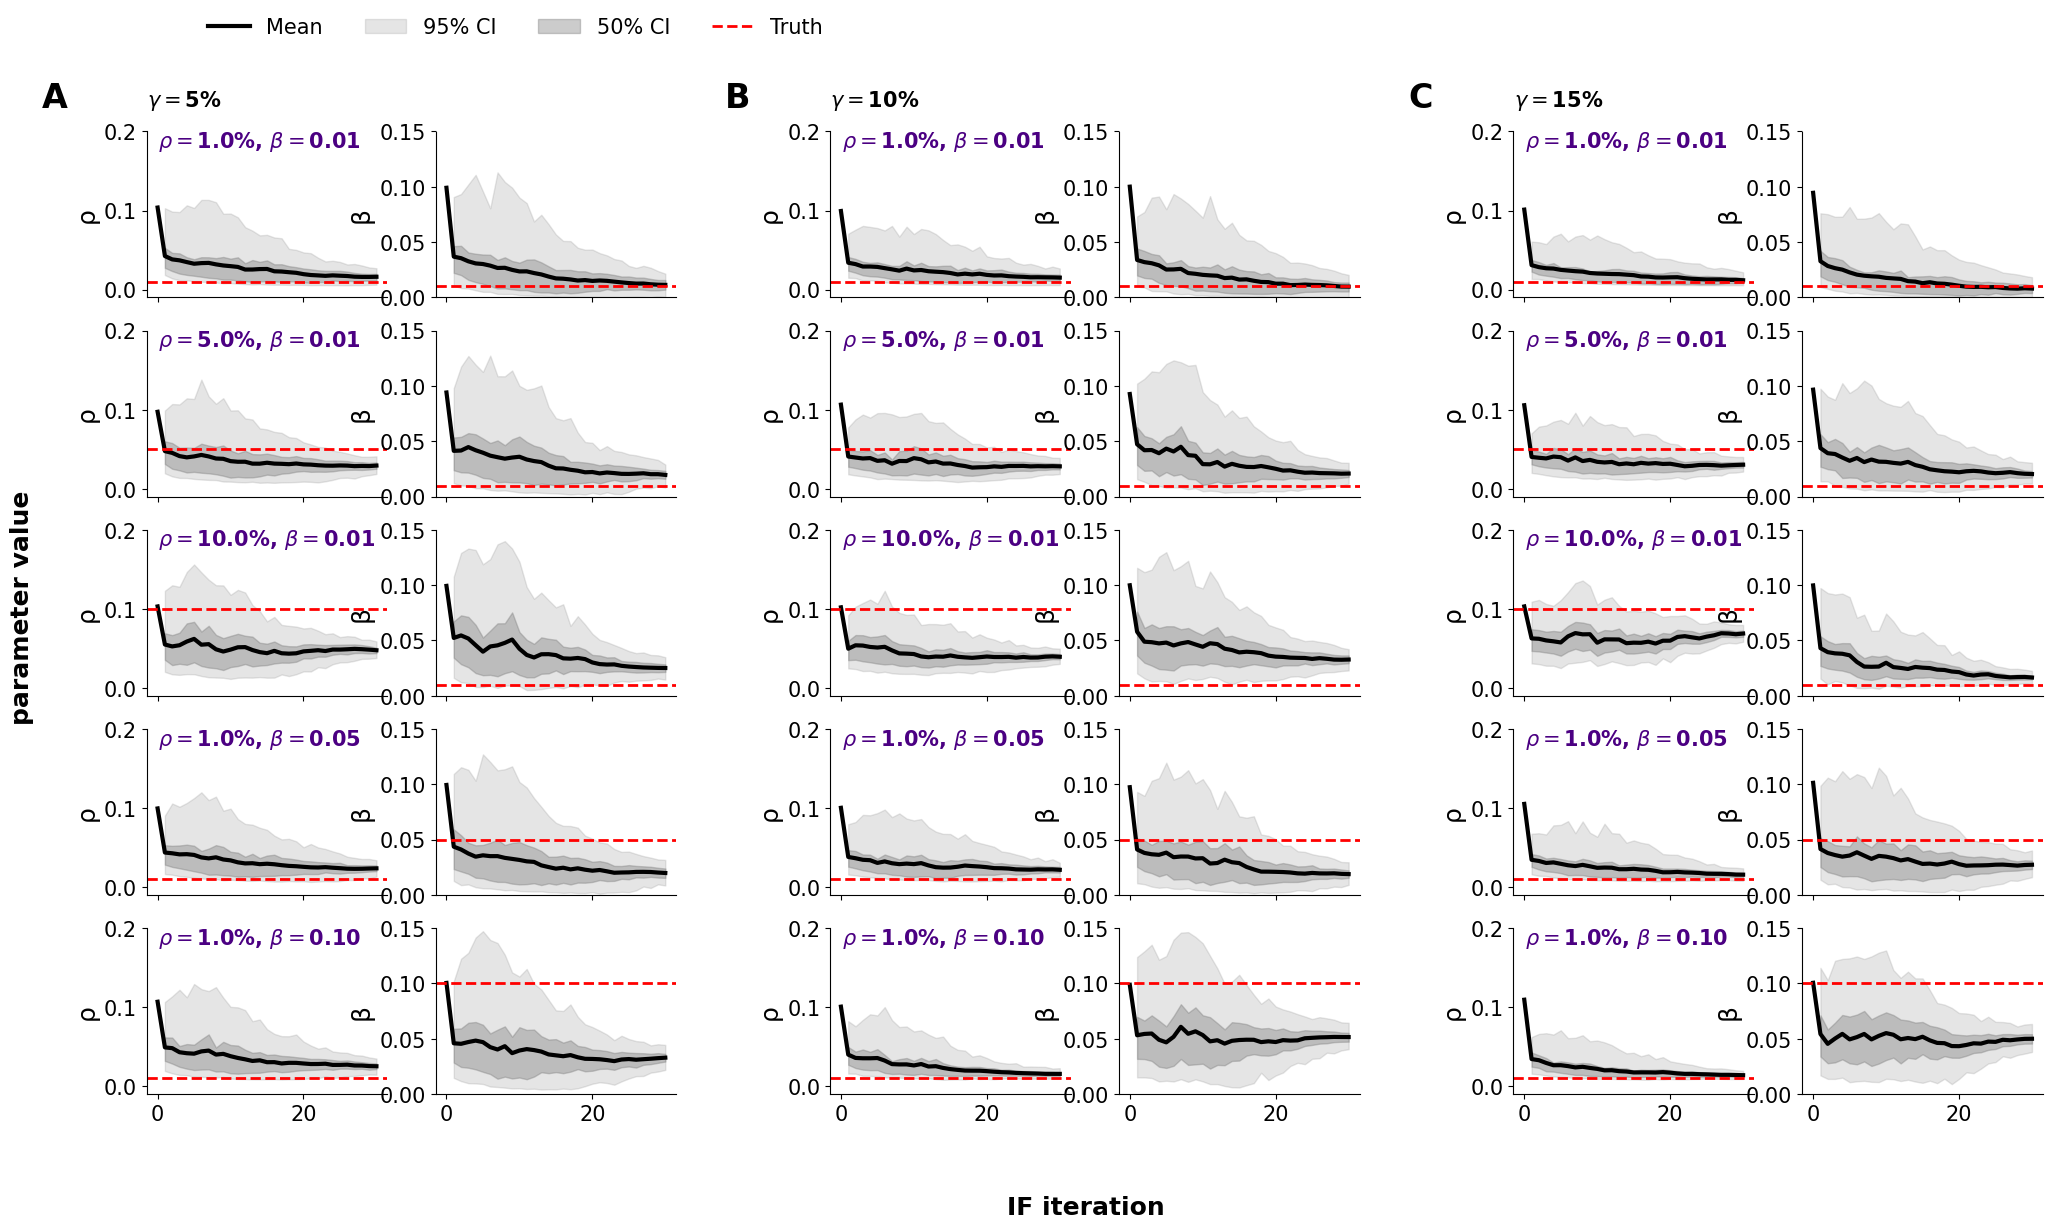

In [38]:
sce_df = scenarios_large_df.query("rho==0.01 or beta==0.01").reset_index(drop=True)
sce_df = sce_df[sce_df.rho!=0.15].reset_index(drop=True)

fig     = plt.figure(constrained_layout=True, figsize=(20.5, 12.5))
subfigs = fig.subfigures(1, 3, hspace=0.03, wspace=0.03, width_ratios=[1/3, 1/3, 1/3])

letters = ["A", "B", "C"]
for idx_gamma, γ in enumerate([0.05, 0.1, 0.15]):

    sce_gamma_df = sce_df[sce_df.gamma==γ].reset_index(drop=True)
    axes = subfigs[idx_gamma].subplots(5, 2, sharex=True, sharey=False)

    subfigs[idx_gamma].suptitle('{}'.format(letters[idx_gamma]),
                                    weight='bold', x=-0.01, y=0.92, fontsize=24)

    axes[0, 0].text(s = r"$\gamma=${:0.0f}%".format(γ*100),
                    weight='bold',
                    x=0.001, y=1.15,
                    transform=axes[0, 0].transAxes)

    #####-#####-#####-#####    #####-#####-#####-#####     #####-#####-#####-#####
    for i_ax in range(5):
        row = sce_gamma_df.iloc[i_ax]

        samples_path      = os.path.join(path_to_samples, row["scenario"], f"{infer_id}posterior.npz")
        samples_inference = np.load(samples_path)

        θpost = samples_inference["posterior"]
        θmle  = samples_inference["mle"]
        Nif   = θpost.shape[-1]
        θpost = θpost[:, :, :, :].mean(-2)

        ρ_df = create_df_response(θpost[0, :, :].T, time=Nif)
        β_df = create_df_response(θpost[1, :, :].T, time=Nif)

        p_dfs       = [ρ_df, β_df]
        param_label = ["ρ", "β"]
        p_truth     = [row.rho, row.beta]

        parameters_range  = np.array([[-0.01, 20/100], [0, 0.15]])
        convergence_plot(θmle, p_dfs, parameters_range, param_label, ax=axes[i_ax, :], fig=fig, param_truth=p_truth)
        axes[i_ax, 0].legend().remove(); axes[i_ax, 1].legend().remove()
        axes[i_ax, 1].set_xlabel(None)


        axes[i_ax, 1].spines['right'].set_visible(False)
        axes[i_ax, 1].spines['top'].set_visible(False)

        axes[i_ax, 0].spines['right'].set_visible(False)
        axes[i_ax, 0].spines['top'].set_visible(False)

        axes[i_ax, 0].text(x=0.1, y=0.18,
                        s=r"$\rho=${:0.1f}%, $\beta=${:0.2f}".format(row.rho*100, row.beta),
                            weight = 'bold',
                            color = "indigo")

fig.supylabel("parameter value", weight='bold', x=-0.025)
fig.supxlabel("IF iteration", weight='bold', y=0.01)

axes[0, 0].legend(loc="upper left", bbox_to_anchor=(-5.5, 1.8), ncol=4, frameon=False)
fig.savefig(os.path.join("figures", "convergences_low_rho_beta.png"),
                            dpi=300, bbox_inches='tight', transparent=True)
